In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patheffects
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, roc_auc_score, confusion_matrix, roc_curve, ConfusionMatrixDisplay
import joblib
import sys
sys.path.append('/app/notebooks/hdfs')
from utils import *

##### Chargement des donnees pretraitees

In [2]:
try:
    X = joblib.load(PROCESSED_DIR / 'X_preprocessed.pkl')
    y = joblib.load(PROCESSED_DIR / 'y_preprocessed.pkl')
except FileNotFoundError:
    print(" Fichiers de donnees pretraitees non trouves.")
    sys.exit(1)

n_success = sum(y==0)
n_fail = sum(y==1)
ratio = n_success / n_fail
print(f"Shape de X: {X.shape}")

Shape de X: (575061, 9)


In [3]:
RANDOM_STATE = 42
N_SPLITS = 10

In [4]:
#  Definition des classifieurs
# regressions logistiques
lr = LogisticRegression(max_iter=1000, random_state=RANDOM_STATE, solver='liblinear')

# random forest
rf = RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE, n_jobs=-1)

models = {
    'Logistic Regression': {
        'estimator': LogisticRegression(max_iter=1000, random_state=42),
        'results': {'precision': [], 'recall': [], 'auc': [], 'f1': []}
    },
    'Random Forest': {
        'estimator': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
        'results': {'precision': [], 'recall': [], 'auc': [], 'f1': []}
    }
}


In [5]:
# Configuration de la Cross-Validation Stratifiée
cv = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)

In [6]:
print("Entraînement en cours...\n")

last_y_test = None 
last_y_proba = {}  
last_y_pred = {}  

# Boucle principale de la Validation croisee
for fold, (train_idx, test_idx) in enumerate(cv.split(X, y), 1):
    

    X_train = X.iloc[train_idx]
    X_test = X.iloc[test_idx]
    y_train = y.iloc[train_idx]
    y_test = y.iloc[test_idx]

    print(f"\n--- Fold {fold:2d}/{N_SPLITS} ---")
    
    for name, model_data in models.items():
        estimator = model_data['estimator']
        results = model_data['results']
        
        # entrainement
        estimator.fit(X_train, y_train)
        
        # prediction
        y_pred = estimator.predict(X_test)
        y_proba = estimator.predict_proba(X_test)[:, 1]
        
        # Stockage des metrique
        results['precision'].append(precision_score(y_test, y_pred))
        results['recall'].append(recall_score(y_test, y_pred))
        results['auc'].append(roc_auc_score(y_test, y_proba))
        
        print(f"  {name}: AUC={results['auc'][-1]:.4f}, Precision={results['precision'][-1]:.4f}, Recall={results['recall'][-1]:.4f}")

        if fold == N_SPLITS:
            last_y_proba[name] = y_proba
            last_y_pred[name] = y_pred 

    if fold == N_SPLITS:
        last_y_test = y_test

print("\n Cross-Validation termine")

Entraînement en cours...


--- Fold  1/10 ---
  Logistic Regression: AUC=0.9558, Precision=0.9641, Recall=0.7648
  Random Forest: AUC=0.9657, Precision=0.9968, Recall=0.9222

--- Fold  2/10 ---
  Logistic Regression: AUC=0.9580, Precision=0.9478, Recall=0.7760
  Random Forest: AUC=0.9666, Precision=0.9942, Recall=0.9127

--- Fold  3/10 ---
  Logistic Regression: AUC=0.9576, Precision=0.9582, Recall=0.7623
  Random Forest: AUC=0.9661, Precision=0.9955, Recall=0.9138

--- Fold  4/10 ---
  Logistic Regression: AUC=0.9539, Precision=0.9514, Recall=0.7441
  Random Forest: AUC=0.9610, Precision=0.9941, Recall=0.9074

--- Fold  5/10 ---
  Logistic Regression: AUC=0.9594, Precision=0.9429, Recall=0.7458
  Random Forest: AUC=0.9673, Precision=0.9929, Recall=0.9097

--- Fold  6/10 ---
  Logistic Regression: AUC=0.9545, Precision=0.9488, Recall=0.7488
  Random Forest: AUC=0.9617, Precision=0.9974, Recall=0.9109

--- Fold  7/10 ---
  Logistic Regression: AUC=0.9598, Precision=0.9535, Recall=0.7548

In [7]:
# Calcul des moyennes
summary_data = {}
for name, model_data in models.items():
    avg_metrics = {
        'Précision Moyenne': np.mean(model_data['results']['precision']),
        'Rappel Moyen': np.mean(model_data['results']['recall']),
        'AUC Moyenne': np.mean(model_data['results']['auc'])
    }
    summary_data[name] = avg_metrics

results_df = pd.DataFrame(summary_data).T
print("\n Résultats Moyens de la Cross-Validation:")
print(results_df)


 Résultats Moyens de la Cross-Validation:
                     Précision Moyenne  Rappel Moyen  AUC Moyenne
Logistic Regression           0.954288      0.757514     0.956967
Random Forest                 0.995475      0.914717     0.964470


In [8]:
# Affichage du meilleur modèle basé sur l'AUC
best_model_name = results_df['AUC Moyenne'].idxmax()
best_auc = results_df['AUC Moyenne'].max()

print(f"\n Meilleur modele: {best_model_name} (AUC = {best_auc:.4f})")



 Meilleur modele: Random Forest (AUC = 0.9645)


#### Visualisation de la Performance

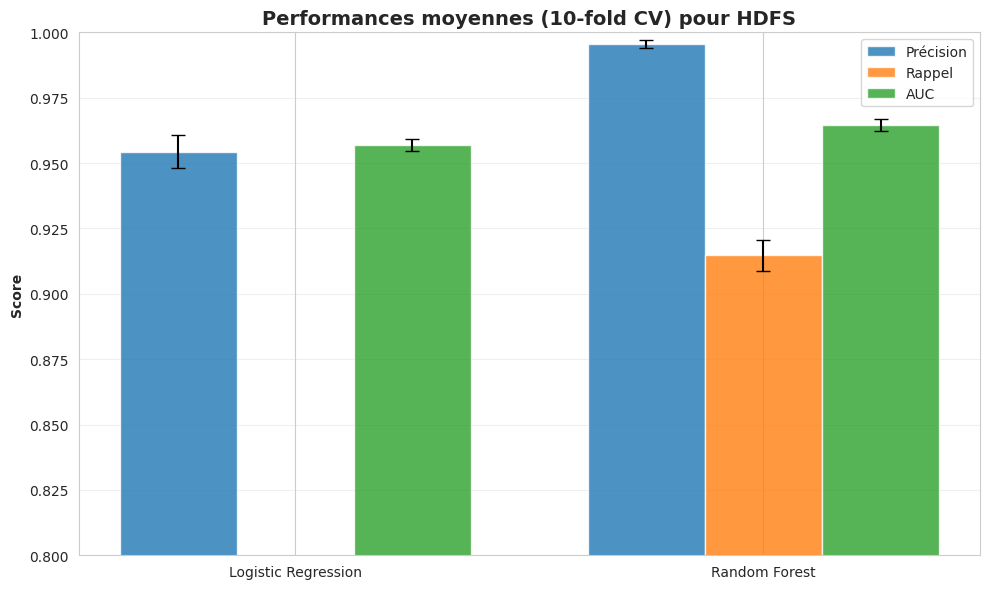

In [9]:
fig, ax = plt.subplots(figsize=(10, 6))

models_names = list(models.keys())
x = np.arange(len(models_names))
width = 0.25

# Calculer moyennes et std
precision_means = [np.mean(models[m]['results']['precision']) for m in models_names]
precision_stds = [np.std(models[m]['results']['precision']) for m in models_names]

recall_means = [np.mean(models[m]['results']['recall']) for m in models_names]
recall_stds = [np.std(models[m]['results']['recall']) for m in models_names]

auc_means = [np.mean(models[m]['results']['auc']) for m in models_names]
auc_stds = [np.std(models[m]['results']['auc']) for m in models_names]

# Barres avec erreurs
ax.bar(x - width, precision_means, width, yerr=precision_stds, 
       label='Précision', alpha=0.8, capsize=5)
ax.bar(x, recall_means, width, yerr=recall_stds, 
       label='Rappel', alpha=0.8, capsize=5)
ax.bar(x + width, auc_means, width, yerr=auc_stds, 
       label='AUC', alpha=0.8, capsize=5)

ax.set_ylabel('Score', fontweight='bold')
ax.set_title('Performances moyennes (10-fold CV) pour HDFS', fontweight='bold', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(models_names)
ax.legend()
ax.set_ylim([0.8, 1.0])
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(MODELS_DIR / 'results_barplot.png', dpi=300)
plt.show()

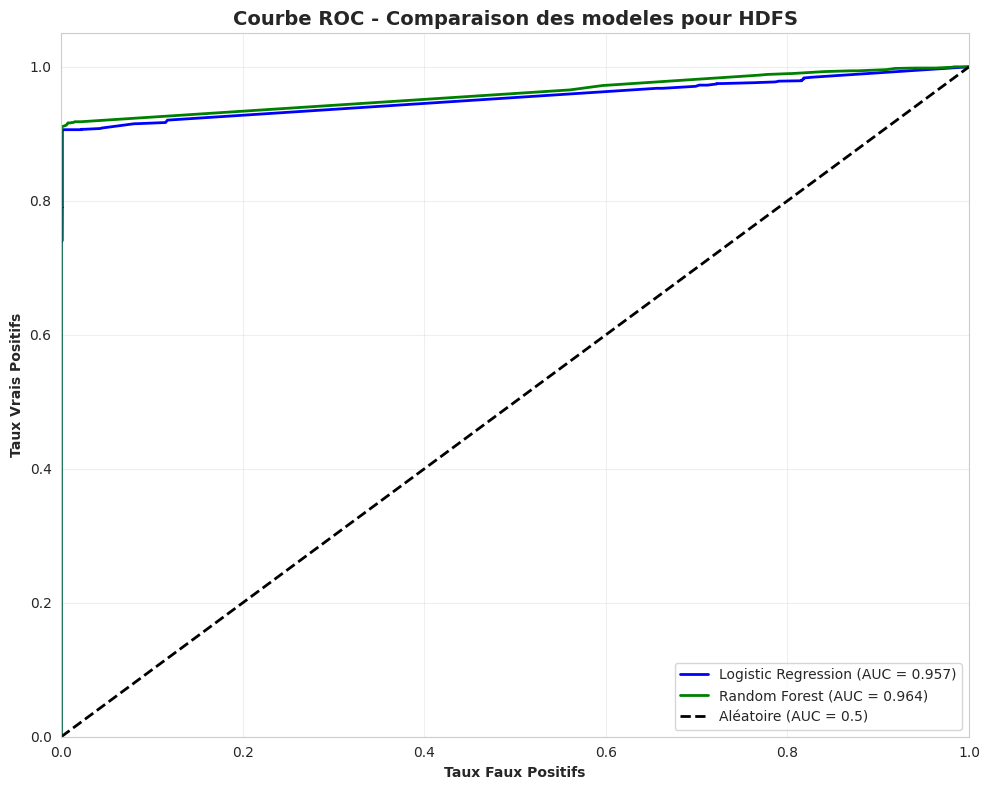

In [10]:


fig, ax = plt.subplots(figsize=(10, 8))

colors = ['blue', 'green']

for idx, (name, model_data) in enumerate(models.items()):
   
    X_train_last  = X.iloc[train_idx]
    X_test_last = X.iloc[test_idx]
    y_train_last = y.iloc[train_idx]
    y_test_last = y.iloc[test_idx]
    
    
    model_data['estimator'].fit(X_train_last, y_train_last)
    y_proba = model_data['estimator'].predict_proba(X_test_last)[:, 1]
    
   
    fpr, tpr, _ = roc_curve(y_test_last, y_proba)
    auc_score = np.mean(model_data['results']['auc'])
    
    ax.plot(fpr, tpr, color=colors[idx], lw=2, 
            label=f'{name} (AUC = {auc_score:.3f})')


ax.plot([0, 1], [0, 1], 'k--', lw=2, label='Aléatoire (AUC = 0.5)')

ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('Taux Faux Positifs', fontweight='bold')
ax.set_ylabel('Taux Vrais Positifs', fontweight='bold')
ax.set_title('Courbe ROC - Comparaison des modeles pour HDFS', fontweight='bold', fontsize=14)
ax.legend(loc="lower right")
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

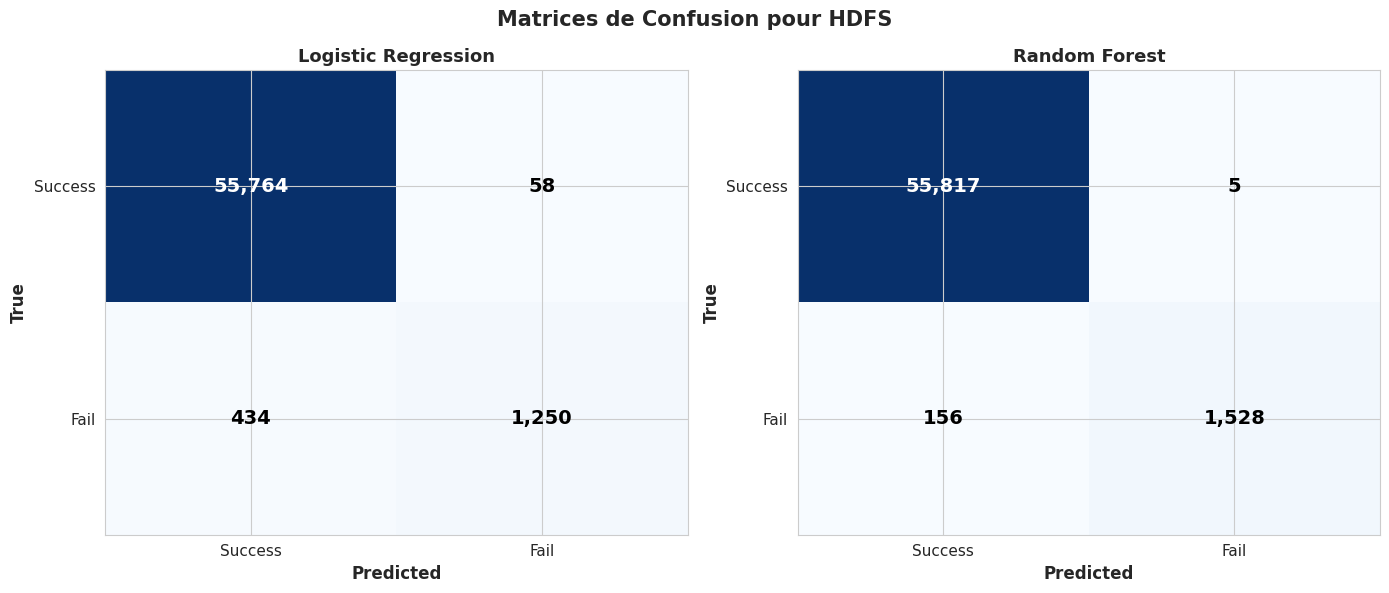

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

for idx, (name, model_data) in enumerate(models.items()):
    X_train_last = X.iloc[train_idx]
    X_test_last = X.iloc[test_idx]
    y_train_last = y.iloc[train_idx]
    y_test_last = y.iloc[test_idx]
    
    
    model_data['estimator'].fit(X_train_last, y_train_last)
    y_pred = model_data['estimator'].predict(X_test_last)
    
    # Matrice de confusion
    cm = confusion_matrix(y_test_last, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    # Plot
    im = axes[idx].imshow(cm, cmap='Blues', aspect='auto', vmin=0, vmax=cm.max())
    
    # Valeurs
    for i in range(2):
        for j in range(2):
            count = cm[i, j]
            text_color = 'white' if count > cm.max()/2 else 'black'
            
            axes[idx].text(j, i, f'{count:,}',
                          ha='center', va='center',
                          color=text_color, fontsize=14, fontweight='bold')
    
    # Labels
    axes[idx].set_xticks([0, 1])
    axes[idx].set_yticks([0, 1])
    axes[idx].set_xticklabels(['Success', 'Fail'], fontsize=11)
    axes[idx].set_yticklabels(['Success', 'Fail'], fontsize=11)
    axes[idx].set_xlabel('Predicted', fontweight='bold', fontsize=12)
    axes[idx].set_ylabel('True', fontweight='bold', fontsize=12)
    axes[idx].set_title(name, fontweight='bold', fontsize=13)
    

plt.suptitle('Matrices de Confusion pour HDFS', fontweight='bold', fontsize=15)
plt.tight_layout()
plt.show()

#### Sauvegarder le meilleur modèle

\Reentraienement du modele final (Random Forest) sur toutes les donnees

=== TOP 15 ÉVÉNEMENTS LES PLUS IMPORTANTS ===

 1. E20: 0.2981
 2. E26: 0.2723
 3. E9: 0.1615
 4. E5: 0.1176
 5. E21: 0.1051
 6. E6: 0.0264
 7. E3: 0.0098
 8. E4: 0.0076
 9. E2: 0.0017


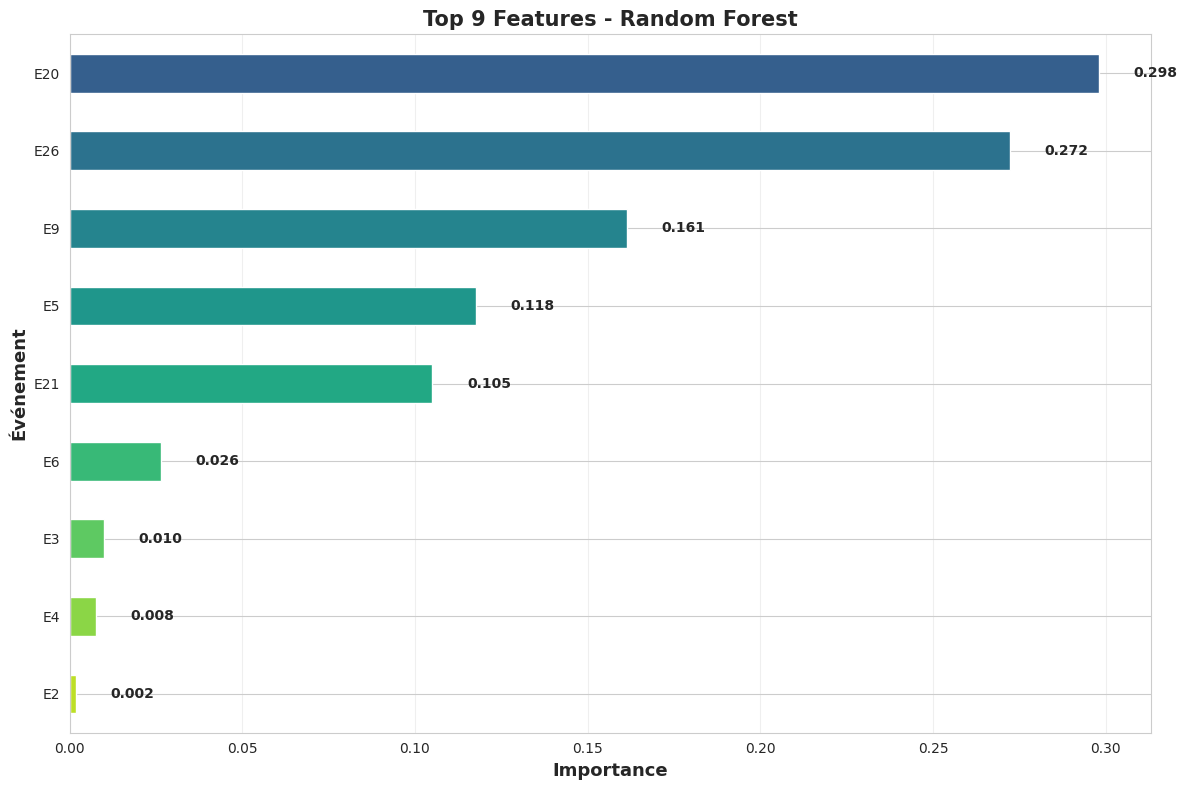

['/data/hdfs/models/results.pkl']

In [12]:

if best_model_name == 'Logistic Regression':
    final_model = LogisticRegression(max_iter=1000, random_state=RANDOM_STATE, solver='liblinear')
else:
    final_model = RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE, n_jobs=-1)

print(f"\Reentraienement du modele final ({best_model_name}) sur toutes les donnees")
final_model.fit(X, y)

importances = pd.Series(
        final_model.feature_importances_,
        index=X.columns
    ).sort_values(ascending=False)
    
print("\n=== TOP 15 ÉVÉNEMENTS LES PLUS IMPORTANTS ===\n")
for i, (event, imp) in enumerate(importances.head(15).items(), 1):
        print(f"{i:2d}. {event}: {imp:.4f}")
    
    # Visualisation
fig, ax = plt.subplots(figsize=(12, 8))
    
top_n = min(15, len(importances))
colors = plt.cm.viridis(np.linspace(0.3, 0.9, top_n))
    
importances.head(top_n).plot(kind='barh', color=colors, ax=ax)
    
ax.set_xlabel('Importance', fontweight='bold', fontsize=13)
ax.set_ylabel('Événement', fontweight='bold', fontsize=13)
ax.set_title(f'Top {top_n} Features - Random Forest', fontweight='bold', fontsize=15)
ax.invert_yaxis()
ax.grid(axis='x', alpha=0.3)
    
for i, (event, imp) in enumerate(importances.head(top_n).items()):
    ax.text(imp + 0.01, i, f'{imp:.3f}', 
               va='center', fontsize=10, fontweight='bold')
    
plt.tight_layout()
plt.show()

model_filename = f'{best_model_name.lower().replace(" ", "_")}.pkl'
joblib.dump(final_model, MODELS_DIR / model_filename)
joblib.dump(results_df, MODELS_DIR / 'results.pkl')